# Spatial Joins
notebook referenced: https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb

In [2]:
from IPython.core.display import Image
Image(url="http://wiki.gis.com/wiki/images/f/fc/SpaitalJoin.jpg")

A spatial join uses **binary predicates** to combine two GeoDataFrames based on the spatial relationship between their geometries.

A common use case might be a spatial join between a point layer and a polygon layer where you want to retain the point geometries and grab the attributes of the intersecting polygons.


\* (A Binary Predicate is a Binary Function whose result represents the truth or falsehood of some condition. A Binary Predicate might, for example, be a function that takes two arguments and tests whether they are equal.)

In [3]:
from IPython.core.display import Image 
Image(url='https://web.natur.cuni.cz/~langhamr/lectures/vtfg1/mapinfo_1/about_gis/Image23.gif')

## Types of Spatial Joins
This is all similar to sql which makes sense since there is an equivalent PostGIS query

### Left Outer Join

(how='left') --> we keep all rows from the left and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right if they intersect and lose right rows that don't intersect. 

### Right Outer Join

(how='right') --> we keep all rows from the right and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the left if they intersect and lose left rows that don't intersect.

### Inner Join

(how='inner') --> we keep rows from the right and left only where their binary predicate is True. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not.

## Doing it with GeoDataframes

In [5]:
%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay

# NYC Boroughs
zippath = datasets.get_path('nybb')
polydf = read_file(zippath)

# Generate points
b = [int(x) for x in polydf.total_bounds]
N = 8
pointdf = GeoDataFrame([
    {'geometry': Point(x, y), 'value1': x + y, 'value2': x - y}
    for x, y in zip(range(b[0], b[2], int((b[2] - b[0]) / N)),
                    range(b[1], b[3], int((b[3] - b[1]) / N)))])

# Make sure they're using the same coordinate reference system (CRS)
pointdf.crs = polydf.crs

In [8]:
pointdf

,geometry,value1,value2
0,POINT (913175 120121),1033296,793054
1,POINT (932450 139211),1071661,793239
2,POINT (951725 158301),1110026,793424
3,POINT (971000 177391),1148391,793609
4,POINT (990275 196481),1186756,793794
5,POINT (1009550 215571),1225121,793979
6,POINT (1028825 234661),1263486,794164
7,POINT (1048100 253751),1301851,794349
8,POINT (1067375 272841),1340216,794534


In [9]:
polydf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


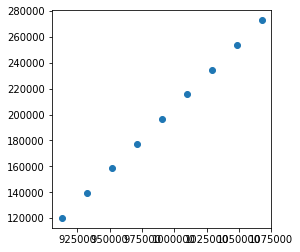

In [10]:
pointdf.plot()

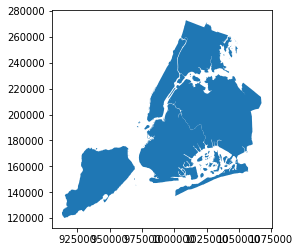

In [11]:
polydf.plot()

### Left Outer Join
The 8 points have taken on some of the attributes that intersected with that of the polygons.

Those that did not intersect are left with null values.

In [17]:
from geopandas.tools import sjoin
join_left_df = sjoin(pointdf, polydf, how="left")
join_left_df

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,POINT (913175 120121),1033296,793054,NaN,NaN,NaN,NaN,NaN
1,POINT (932450 139211),1071661,793239,0.0,5.0,Staten Island,330470.010332,1.623820e+09
2,POINT (951725 158301),1110026,793424,0.0,5.0,Staten Island,330470.010332,1.623820e+09
3,POINT (971000 177391),1148391,793609,NaN,NaN,NaN,NaN,NaN
4,POINT (990275 196481),1186756,793794,NaN,NaN,NaN,NaN,NaN
5,POINT (1009550 215571),1225121,793979,1.0,4.0,Queens,896344.047763,3.045213e+09
6,POINT (1028825 234661),1263486,794164,4.0,2.0,Bronx,464392.991824,1.186925e+09
7,POINT (1048100 253751),1301851,794349,NaN,NaN,NaN,NaN,NaN
8,POINT (1067375 272841),1340216,794534,NaN,NaN,NaN,NaN,NaN


### Right Outer Join
The 5 polygons have taken on some of the attributes that intersected with that of the points.

Those that did not intersect are left with null values.

Staten Island is repeated because there were two points that fell within it.

In [16]:
join_right_df = sjoin(pointdf, polydf, how="right")
join_right_df

,index_left,value1,value2,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
index_right,,,,,,,,
0,1.0,1071661.0,793239.0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
0,2.0,1110026.0,793424.0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,5.0,1225121.0,793979.0,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
4,6.0,1263486.0,794164.0,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...
2,NaN,NaN,NaN,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,NaN,NaN,NaN,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...


### Inner Join
Only the intersecting parts are kept and combined together, resulting in no null values.

Staten Island is still repeated twice because there are two intersecting points.

In [15]:
join_inner_df = sjoin(pointdf, polydf, how="inner")
join_inner_df

,geometry,value1,value2,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
1,POINT (932450 139211),1071661,793239,0,5,Staten Island,330470.010332,1.623820e+09
2,POINT (951725 158301),1110026,793424,0,5,Staten Island,330470.010332,1.623820e+09
5,POINT (1009550 215571),1225121,793979,1,4,Queens,896344.047763,3.045213e+09
6,POINT (1028825 234661),1263486,794164,4,2,Bronx,464392.991824,1.186925e+09
